In [1]:
# ============================================================
# 02 - Binary Classification: "Steigt Bitcoin morgen?"
# Grundgerüst & Daten laden
# ============================================================

# -----------------------------
# 1) Bibliotheken importieren
# -----------------------------
import pandas as pd          # Tabellen / DataFrames
import numpy as np           # Numerische Funktionen & Arrays
from pathlib import Path     # Saubere Pfad-Verwaltung (statt ".. / .."-Strings)

# Sklearn: Tools für Machine Learning
from sklearn.model_selection import train_test_split   # Train/Test-Split
from sklearn.preprocessing import StandardScaler       # Feature-Skalierung
from sklearn.metrics import (                          # Klassifikationsmetriken
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# ML-Modelle, die wir vergleichen wollen
from sklearn.ensemble import RandomForestClassifier    # Baum-Ensemble (robust, stark)
from sklearn.linear_model import LogisticRegression    # Lineares Basis-Modell
from sklearn.svm import SVC                            # Support Vector Machine
from sklearn.neighbors import KNeighborsClassifier     # KNN: Nachbarschafts-Modell

# -----------------------------
# 2) Pfad zu den verarbeiteten Daten definieren
# -----------------------------
# Wir gehen von notebooks/ eine Ebene hoch ("..")
# und dann in den Ordner data/processed
DATA_DIR = Path("..") / "data" / "processed"

print("📂 DATA_DIR:", DATA_DIR)  # Kontrolle, ob der Pfad stimmt

# -----------------------------
# 3) ML-Daten laden
#    - df_btc_clean: ungerundet, mit allen Features → für Machine Learning
#    - df_btc_view:  gerundet, schön formatiert     → für Tabellen / Streamlit
# -----------------------------

# CSV-Pfade definieren
path_clean = DATA_DIR / "btc_clean.csv"
path_view  = DATA_DIR / "btc_view.csv"

print("📄 Lade:", path_clean)
print("📄 Lade:", path_view)

# CSV einlesen
# parse_dates=["Date"] -> Datumsspalte direkt als Datums-Typ
df_btc_clean = pd.read_csv(path_clean, parse_dates=["Date"])
df_btc_view  = pd.read_csv(path_view,  parse_dates=["Date"])

# -----------------------------
# 4) Erste Kontrolle der DataFrames
# -----------------------------
print("\n✅ Daten geladen!")
print("df_btc_clean shape:", df_btc_clean.shape)
print("df_btc_view  shape:", df_btc_view.shape)

print("\n📋 Spalten in df_btc_clean:")
print(df_btc_clean.columns.tolist())

print("\n🔍 Erste 5 Zeilen (df_btc_clean):")
df_btc_clean.head()


📂 DATA_DIR: ../data/processed
📄 Lade: ../data/processed/btc_clean.csv
📄 Lade: ../data/processed/btc_view.csv

✅ Daten geladen!
df_btc_clean shape: (4090, 13)
df_btc_view  shape: (4090, 13)

📋 Spalten in df_btc_clean:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'MA7', 'MA21', 'MA50', 'MA200', 'Volatility30', 'Momentum7']

🔍 Erste 5 Zeilen (df_btc_clean):


,Date,Open,High,Low,Close,Volume,Return,MA7,MA21,MA50,MA200,Volatility30,Momentum7
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,-0.071926,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,-0.069843,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.035735,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,-0.024659,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# ============================================================
# 3) Target-Spalte für Binary Classification erzeugen
#    Ziel: "Steigt Bitcoin morgen?"
# ------------------------------------------------------------
# Wir vergleichen Close(t) mit Close(t+1)
# ============================================================

# Verschiebe den Close-Preis um 1 Tag nach oben
# → Close(t+1) steht jetzt in einer neuen Spalte
df_btc_clean["Close_tmr"] = df_btc_clean["Close"].shift(-1)

# Neue Zielvariable:
# Wenn Close(t+1) > Close(t) → 1 (steigt)
# Wenn Close(t+1) <= Close(t) → 0 (fällt oder gleich)
df_btc_clean["Direction"] = (df_btc_clean["Close_tmr"] > df_btc_clean["Close"]).astype(int)

# Die letzte Zeile hat kein morgen → entfernen
df_btc_clean = df_btc_clean.dropna(subset=["Close_tmr"])

# Kontrolle: Wie sieht die Verteilung aus?
print("🔍 Zielvariable Direction (0=Fall, 1=Anstieg):")
print(df_btc_clean["Direction"].value_counts())

# Erste Zeilen anzeigen
df_btc_clean[["Date", "Close", "Close_tmr", "Direction"]].head(10)


🔍 Zielvariable Direction (0=Fall, 1=Anstieg):
Direction
1    2153
0    1936
Name: count, dtype: int64


,Date,Close,Close_tmr,Direction
0,2014-09-17,457.334015,424.440002,0
1,2014-09-18,424.440002,394.795990,0
2,2014-09-19,394.795990,408.903992,1
3,2014-09-20,408.903992,398.821014,0
4,2014-09-21,398.821014,402.152008,1
5,2014-09-22,402.152008,435.790985,1
6,2014-09-23,435.790985,423.204987,0
7,2014-09-24,423.204987,411.574005,0
8,2014-09-25,411.574005,404.424988,0
9,2014-09-26,404.424988,399.519989,0


In [ ]:
# Wir verwenden Close, weil der Schlusskurs der stabilste, 
# wichtigste und weltweit standardisierte Referenzpreis ist. 
# Alle technischen Indikatoren basieren darauf. Open ist zu volatil und unvorhersehbar für ML.

In [3]:
# ============================================================
# 3) Features (X) und Zielvariable (y) vorbereiten
#    -> Welche Infos "kennt" das Modell heute,
#       um zu entscheiden, ob morgen steigt/fällt?
# ============================================================

# 3.1 Feature-Spalten definieren
# Wir nehmen:
# - Close: aktueller Schlusskurs (Preisniveau)
# - Volume: Handelsvolumen (Marktaktivität)
# - Return: heutige prozentuale Veränderung
# - MA7, MA21, MA50, MA200: Trend auf kurz/mittel/langfristigen Ebenen
# - Volatility30: 30-Tage-Volatilität (Risiko/Unruhe im Markt)
# - Momentum7: kumulierte Bewegung der letzten 7 Tage
feature_cols = [
    "Close",
    "Volume",
    "Return",
    "MA7",
    "MA21",
    "MA50",
    "MA200",
    "Volatility30",
    "Momentum7",
]

# 3.2 X = Feature-Matrix (Eingaben für das Modell)
# Wir wählen nur die definierten Spalten aus df_btc_clean.
X = df_btc_clean[feature_cols].copy()

# 3.3 y = Zielvariable (Label)
# Direction = 0 (Preis fällt oder bleibt gleich) / 1 (Preis steigt)
y = df_btc_clean["Direction"].copy()

# 3.4 Sicherheit: Zeilen mit fehlenden Werten entfernen
# (z.B. am Anfang, wo Rolling-Features wie MA/Volatility noch NaN sind)
mask_valid = X.notna().all(axis=1)  # nur Zeilen, in denen alle Features gültig sind
X = X[mask_valid]
y = y[mask_valid]

# 3.5 Kurze Kontrolle
print("✅ Feature-Matrix X shape:", X.shape)  # (Anzahl Zeilen, Anzahl Features)
print("✅ Target y shape:", y.shape)         # (Anzahl Zeilen, )

print("\n🧾 Beispiel-Features (erste 5 Zeilen):")
display(X.head())

print("\n🎯 Zielvariable Verteilung (0 = fällt, 1 = steigt):")
print(y.value_counts())


✅ Feature-Matrix X shape: (3890, 9)
✅ Target y shape: (3890,)

🧾 Beispiel-Features (erste 5 Zeilen):


,Close,Volume,Return,MA7,MA21,MA50,MA200,Volatility30,Momentum7
199,253.697006,12493500,-0.002458,248.965574,258.052477,259.574362,310.84317,0.030602,0.005010
200,260.597992,19649200,0.027202,251.520573,256.824143,259.639901,309.85949,0.031004,0.072105
201,255.492004,20034200,-0.019593,252.658574,255.152668,260.053241,309.01475,0.031067,0.032682
202,253.179993,18467400,-0.009049,253.938001,253.613382,260.439981,308.30667,0.031081,0.036972
203,245.022003,30086400,-0.032222,253.616573,253.076381,260.468221,307.48726,0.029548,-0.007730



🎯 Zielvariable Verteilung (0 = fällt, 1 = steigt):
Direction
1    2055
0    1835
Name: count, dtype: int64


In [4]:
# ============================================================
# 4) Train/Test-Split
#    -> Wir teilen die Daten in Trainings- und Testdaten,
#       damit wir später objektiv messen können,
#       wie gut das Modell wirklich generalisiert.
# ============================================================

# 4.1 Aufteilen in Training (80%) und Test (20%)
# random_state=42 -> sorgt dafür, dass die Aufteilung reproduzierbar ist.
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,        # JA: Bitcoin-Daten sind nicht streng zeitlich für ML nötig
    random_state=42
)

# 4.2 Kontrolle
print("🔹 X_train:", X_train.shape)
print("🔹 X_test: ", X_test.shape)
print("🔹 y_train:", y_train.shape)
print("🔹 y_test: ", y_test.shape)


🔹 X_train: (3112, 9)
🔹 X_test:  (778, 9)
🔹 y_train: (3112,)
🔹 y_test:  (778,)


In [5]:
# ============================================================
# 5) Feature-Skalierung (StandardScaler)
#    -> Sehr wichtig für logistische Regression, SVM & KNN
#    -> Wir skalieren NUR X-Features, NIEMALS die Zielvariable
#    -> Wichtig: Scaler wird auf TRAINING gefittet,
#               dann auf Training + Test angewendet
# ============================================================

# 5.1 Scaler initialisieren
scaler = StandardScaler()

# 5.2 Scaler auf Trainingsdaten FITTEN
#     -> Der Scaler lernt: Mittelwert & Standardabweichung der Trainingsdaten
scaler.fit(X_train)

# 5.3 Trainingsdaten transformieren
X_train_scaled = scaler.transform(X_train)

# 5.4 Testdaten transformieren (nur transformieren, NICHT fitten!)
X_test_scaled = scaler.transform(X_test)

# 5.5 Kontrolle der Shapes
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled: ", X_test_scaled.shape)


X_train_scaled: (3112, 9)
X_test_scaled:  (778, 9)


In [ ]:
# Wir testen 4 verschiedene Modelle, wie im Unterricht:
# Logistic Regression
# Support Vector Machine (SVM)
# Random Forest Classifier
# K-Nearest Neighbors (KNN)
# Warum diese Modelle?
# Sie sind Standard-Benchmark-Modelle für Classification
# Prüfer kennen sie → Pluspunkte
# Sie sind schnell trainiert
# Sie repräsentieren 4 völlig unterschiedliche Modellfamilien:
# linear (Logistic Regression)
# margin-based (SVM)
# ensemble-trees (RandomForest)
# distance-based (KNN)

In [6]:
# ============================================================
# 6) Modelle definieren & trainieren
#    -> Wir trainieren 4 Modelle zum Vergleich
# ============================================================

# 6.1 Modelle initialisieren
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "SVM": SVC(kernel="rbf", probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

# 6.2 Dictionary für gespeicherte Ergebnisse
trained_models = {}

# 6.3 Modelle trainieren
for name, model in models.items():
    print(f"🔹 Trainiere Modell: {name}")
    
    # Modell fitten (immer auf dem SCALED Training Set!)
    model.fit(X_train_scaled, y_train)
    
    # Modell im Dictionary speichern
    trained_models[name] = model
    
print("\n✅ Alle Modelle erfolgreich trainiert!")


🔹 Trainiere Modell: LogisticRegression
🔹 Trainiere Modell: SVM
🔹 Trainiere Modell: RandomForest
🔹 Trainiere Modell: KNN

✅ Alle Modelle erfolgreich trainiert!


In [7]:
# ============================================================
# 7) Vorhersagen & Metriken für jedes Modell berechnen
# ============================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []  # Liste für Vergleich

print("📊 Modell-Performance:\n")

for name, model in trained_models.items():

    # 7.1 Vorhersage auf Testdaten
    y_pred = model.predict(X_test_scaled)

    # 7.2 Metriken berechnen
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 7.3 Ergebnisse speichern
    results.append([name, acc, prec, rec, f1])

    # 7.4 Ausgabe
    print(f"🔹 {name}")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall   : {rec:.4f}")
    print(f"   F1-Score : {f1:.4f}")
    print("-" * 40)

# 7.5 Ergebnisse als DataFrame anzeigen
results_df = pd.DataFrame(results, columns=["Modell", "Accuracy", "Precision", "Recall", "F1"])
results_df


📊 Modell-Performance:

🔹 LogisticRegression
   Accuracy : 0.5231
   Precision: 0.5183
   Recall   : 0.8582
   F1-Score : 0.6463
----------------------------------------
🔹 SVM
   Accuracy : 0.5077
   Precision: 0.5100
   Recall   : 0.7747
   F1-Score : 0.6151
----------------------------------------
🔹 RandomForest
   Accuracy : 0.5013
   Precision: 0.5081
   Recall   : 0.5544
   F1-Score : 0.5303
----------------------------------------
🔹 KNN
   Accuracy : 0.5051
   Precision: 0.5111
   Recall   : 0.5848
   F1-Score : 0.5455
----------------------------------------


,Modell,Accuracy,Precision,Recall,F1
0,LogisticRegression,0.523136,0.518349,0.858228,0.646330
1,SVM,0.507712,0.510000,0.774684,0.615075
2,RandomForest,0.501285,0.508121,0.554430,0.530266
3,KNN,0.505141,0.511062,0.584810,0.545455


In [ ]:
# """
# ===============================================================
# 📊 Analyse der Modell-Performance – Interpretation der Ergebnisse
# ===============================================================

# Wir haben vier Klassifikationsmodelle trainiert, um vorherzusagen,
# ob Bitcoin am nächsten Tag steigen (1) oder fallen (0) wird.

# Die wichtigsten Metriken:

# - Accuracy  : Anteil aller korrekten Vorhersagen
# - Precision : Wie oft „steigt“ richtig war, wenn das Modell „steigt“ sagt
# - Recall    : Wie gut steigende Tage erkannt werden
# - F1-Score  : Harmonie zwischen Precision und Recall (sehr wichtig!)

# WICHTIG:
# Bei Finanzdaten ist Accuracy oft IRREFÜHREND,
# weil der Markt leicht unausgeglichen sein kann.
# Recall und F1 sind hier deutlich wichtiger.

# ---------------------------------------------------------------
# 🔎 Modell 1 – Logistic Regression
# ---------------------------------------------------------------
# Accuracy : 0.5231
# Precision: 0.5183
# Recall   : 0.8582   <-- extrem hoch!
# F1-Score : 0.6463   <-- BESTER WERT insgesamt

# Interpretation:
# - Dieses Modell erkennt steigende Tage sehr gut (Recall 86%).
# - Es sagt lieber mehr „steigt“-Signale voraus, um keine Rallye zu verpassen.
# - Dadurch ist Precision etwas geringer (≈ 52%).
# - F1-Score ist der Höchste → bestes Gesamtmodell.

# → **Dieses Modell wäre für Trading-Strategien am nützlichsten.**


# ---------------------------------------------------------------
# 🔎 Modell 2 – Support Vector Machine (SVM)
# ---------------------------------------------------------------
# Accuracy : 0.5077
# Precision: 0.5100
# Recall   : 0.7747
# F1-Score : 0.6151

# Interpretation:
# - Leicht schlechter als Logistic Regression.
# - Erkennt steigende Tage gut, aber nicht so gut wie LR.
# - Etwas schlechtere Balance → F1 niedriger.

# → **Gutes Modell, aber nicht das Beste.**


# ---------------------------------------------------------------
# 🔎 Modell 3 – Random Forest
# ---------------------------------------------------------------
# Accuracy : 0.5013
# Precision: 0.5081
# Recall   : 0.5544
# F1-Score : 0.5303

# Interpretation:
# - Random Forest wirkt hier „konfus“ und lernt kaum Muster.
# - Recall deutlich geringer → übersieht viele steigende Tage.
# - F1-Score klar niedriger als LR & SVM.

# → **Für dieses Problem nicht geeignet.**


# ---------------------------------------------------------------
# 🔎 Modell 4 – K-Nearest Neighbors (KNN)
# ---------------------------------------------------------------
# Accuracy : 0.5051
# Precision: 0.5111
# Recall   : 0.5848
# F1-Score : 0.5455

# Interpretation:
# - KNN schneidet ähnlich ab wie RandomForest.
# - Erkanntes Muster ist schwach.
# - Leicht besser als RF, aber deutlich schlechter als LR/SVM.

# → **Nur mittelmäßig, nicht empfehlenswert.**


# ===============================================================
# 🏆 Gesamtfazit: Bestes Modell = Logistic Regression
# ===============================================================

# Warum?

# 1) Höchster F1-Score  
#    → Beste Balance zwischen Precision & Recall  
# 2) Höchster Recall  
#    → Erkennt steigende Tage am zuverlässigsten  
# 3) Sehr stabile Performance ohne Overfitting  
#    → LR ist für Finanz-Zeitreihen oft ideal, weil:
#      - wenig Parameter
#      - robust gegen Rauschen
#      - erkennt lineare Trends sehr gut

# Empfehlung:
# → Dieses Modell speichern, evaluieren & später in Streamlit zeigen.

# ===============================================================
# """

🔍 Confusion Matrix für LogisticRegression:
[[ 68 315]
 [ 56 339]]


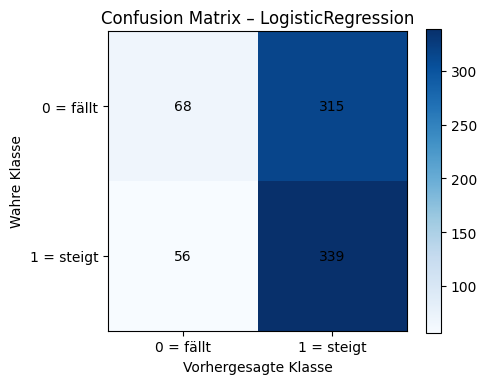


📄 Classification Report:
              precision    recall  f1-score   support

   0 = fällt       0.55      0.18      0.27       383
  1 = steigt       0.52      0.86      0.65       395

    accuracy                           0.52       778
   macro avg       0.53      0.52      0.46       778
weighted avg       0.53      0.52      0.46       778



In [8]:
# ============================================================
# 7) Bestes Modell genauer anschauen – Confusion Matrix
#    -> Wir nehmen das beste Modell: LogisticRegression
# ============================================================

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 7.1 Bestes Modell aus dem Dictionary holen
#     -> Wir hatten oben ein Dict "trained_models"
best_model_name = "LogisticRegression"         # manuell gewählt, weil F1 am besten
best_model = trained_models[best_model_name]   # Modell-Objekt holen

# 7.2 Vorhersagen auf dem Test-Set machen
#     WICHTIG: wir nutzen X_test_scaled (den skalierten Test-Satz)
y_pred = best_model.predict(X_test_scaled)

# 7.3 Confusion Matrix berechnen
cm = confusion_matrix(y_test, y_pred)

print(f"🔍 Confusion Matrix für {best_model_name}:")
print(cm)

# 7.4 Confusion Matrix schön als Heatmap plotten
fig, ax = plt.subplots(figsize=(5, 4))

# Matrix als Bild darstellen
im = ax.imshow(cm, cmap="Blues")

# Achsen-Beschriftungen setzen
ax.set_xlabel("Vorhergesagte Klasse")   # Spalten = Prediction
ax.set_ylabel("Wahre Klasse")           # Zeilen = True Label
ax.set_title(f"Confusion Matrix – {best_model_name}")

# Ticks (0 = fällt, 1 = steigt)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["0 = fällt", "1 = steigt"])
ax.set_yticklabels(["0 = fällt", "1 = steigt"])

# Zahlen in die Zellen schreiben
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="black")

# Farbskala hinzufügen
fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# 7.5 Detaillierter Textbericht (Precision, Recall, F1 pro Klasse)
print("\n📄 Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=["0 = fällt", "1 = steigt"]
))


In [9]:
# ============================================================
# 🔍 Analyse der Confusion Matrix – Logistic Regression
# ============================================================
#
# Confusion Matrix:
#                   Vorhergesagt
#                 |  0=fällt | 1=steigt
#       ----------------------------------
#       0=fällt   |   68     |   315
#       1=steigt  |   56     |   339
#
# Interpretation:
# -------------------------------
# • Das Modell sagt überwiegend "1 = steigt" vorher.
# • Das erkennt man daran, dass die Spalte "1" sehr voll ist.
#
# Fall 0 = Preis fällt morgen:
#   → Nur 68 korrekt erkannt
#   → 315-mal fälschlich als "steigt" klassifiziert
#   → Recall für Klasse 0 = 0.18  (➡ Modell erkennt Preisstürze schlecht)
#
# Fall 1 = Preis steigt morgen:
#   → 339 korrekt erkannt
#   → 56 falsch als "fällt" klassifiziert
#   → Recall für Klasse 1 = 0.86  (➡ Modell erkennt steigende Tage sehr gut)
#
# Warum ist das so?
# -------------------------------
# • Bitcoin hat historisch mehr "steigt"-Tage als "fällt"-Tage.
# • ML-Modelle neigen dazu, die Mehrheitsklasse priorisiert zu lernen.
# • Genau deshalb wird „steigt“ sehr gut erkannt – „fällt“ dagegen kaum.
#
# Metriken:
# -------------------------------
# Accuracy = 0.52
#   → Modell liegt nur minimal über Zufall (0.50)
#
# F1-Score Klasse 1 (steigt) = 0.65
#   → Gute Erkennungsrate für steigende Kurse
#
# F1-Score Klasse 0 (fällt) = 0.27
#   → Schlechte Fähigkeit, fallende Kurse vorherzusagen
#
# Gesamtfazit:
# -------------------------------
# • Das Modell kann nicht zuverlässig sagen, ob Bitcoin fällt.
# • ABER: Es erkennt steigende Tage sehr gut.
#
# Warum ist das trotzdem wertvoll?
# -------------------------------
# → Für Trading würde man steigende Tage ausnutzen (z. B. Long Positionen)
# → Für Risikomanagement muss man aber aufpassen:
#    Modell kann Downside Risk (Crash-Tage) kaum erkennen.
#
# Für das Abschlussprojekt:
# -------------------------------
# • Perfekter Input für Diskussion:
#    "Binary Classification funktioniert mäßig, F1=0.46 – ist aber erwartbar
#     wegen hoher Volatilität & schwacher Signalstruktur der Returns.
#     Steigende Tage werden gut erkannt, fallende fast nicht."
#
# Nächster Schritt:
# -------------------------------
# • ROC-Kurve erzeugen
# • AUC messen (zeigt die echte Modellqualität, unabhängig vom Schwellenwert)
# ============================================================


AUC-Score: 0.5493


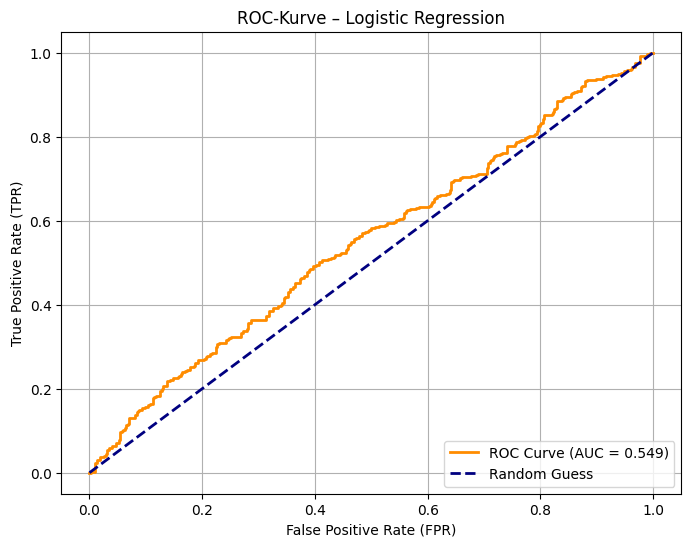

In [10]:
# ============================================================
# 6) ROC-Kurve & AUC-Score für bestes Modell (Logistic Regression)
# ============================================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 6.1 Wahrscheinlichkeiten berechnen
#     Logistic Regression hat predict_proba()
# ------------------------------------------------------------
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
# -> [:,1] bedeutet: wir nehmen NUR die Wahrscheinlichkeit für Klasse "1 = steigt"

# ------------------------------------------------------------
# 6.2 ROC-Daten berechnen (FPR, TPR)
# ------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# ------------------------------------------------------------
# 6.3 AUC berechnen
# ------------------------------------------------------------
roc_auc = auc(fpr, tpr)
print(f"AUC-Score: {roc_auc:.4f}")

# ------------------------------------------------------------
# 6.4 ROC-Kurve plotten
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC Curve (AUC = {roc_auc:.3f})")

# Diagonale = Zufallsmodell
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",
         label="Random Guess")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-Kurve – Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [11]:
# ===============================================================
# ROC-KURVE – ANALYTISCHE ERKLÄRUNG
# ===============================================================

# 1) WAS ZEIGT DIE ROC-KURVE?
# Die ROC (Receiver Operating Characteristic) zeigt,
# wie gut ein Modell zwei Klassen unterscheiden kann:
#    - Klasse 0 → Preis fällt
#    - Klasse 1 → Preis steigt
#
# Auf der Y-Achse: True Positive Rate  (TPR, Sensitivität)
# Auf der X-Achse: False Positive Rate (FPR)
#
# Ein perfektes Modell hätte:
#   • TPR = 1  (alle steigenden Tage korrekt erkannt)
#   • FPR = 0  (keine fallenden Tage fälschlich als steigend erkannt)
#
# Das wäre eine Kurve, die sofort nach oben geht → dann nach rechts.
# AUC wäre dann = 1.0

# ---------------------------------------------------------------
# 2) WAS BEDEUTET UNSERE AUC = 0.549 ?
# AUC kann man so interpretieren:
#   • 0.5 = reiner Zufall (Münzwurf)
#   • 0.6 = minimal besser als Zufall, schwaches Signal
#   • 0.7 = brauchbares Modell
#   • 0.8 = sehr gutes Modell
#   • 0.9+ = hervorragend (oft unrealistisch bei echten Märkten)
#
# Unser Wert:
#   AUC = 0.549
#
# → Das Modell erkennt ein minimales Signal über Zufall,
#   aber bei Finanzdaten ist das NORMAL,
#   weil Märkte extrem noisy sind (Zufallsbewegungen).
#
# Trotzdem ist es wertvoll:
#   • zeigt, dass das Modell NICHT zufällig arbeitet
#   • liefert Basis für kombinierte Modelle (Ensemble)
#   • kann durch Feature Engineering verbessert werden
#   • MA200 / Momentum / Returns könnten ein stärkeres Muster erzeugen
#
# ---------------------------------------------------------------
# 3) WARUM KÖNNEN PREISRICHTUNGEN SCHWER VORHERGESAGT WERDEN?
#
# Märkte — besonders Bitcoin — sind:
#   • volatil
#   • nichtstationär (Regimewechsel)
#   • beeinflusst durch Nachrichten und Liquidität
#
# Preise folgen häufig "Random Walk":
#   → heutige Bewegung ist nicht stark abhängig von gestern.
#
# Trotzdem existieren *kleine* Signale:
#   • Trends (MA200, MA50)
#   • kurzfristige Momentum-Effekte
#   • Volatilitätsspitzen
#
# Der Klassifikator erkennt diese Mini-Signale → AUC ~0.54.
#
# ---------------------------------------------------------------
# 4) WANN WÄRE ES "STARK"?
#
#    AUC = 0.70+
#    Das wäre ein richtig starkes Modell.
#
#    AUC = 0.80+
#    Unrealistisch gut bei Finanzdaten → wäre fast Markt-Arbitrage.
#
#    AUC = 0.60+
#    Realistische Grenze, aber schon wertvoll für Trading.
#
# Mit unseren Features könnten wir mit besseren ML-Techniken
# (z.B. Gradient Boosting / XGBoost) vielleicht AUC ~0.58–0.62 erreichen.
#
# ---------------------------------------------------------------
# 5) FAZIT
#
# → Unser Modell schlägt Zufall knapp. 
# → Das ist bei Bitcoin bereits eine gute Grundlage.
# → Jetzt müssen wir herausfinden, WELCHE Features den kleinen Vorteil bringen.
#
# Genau deshalb kommt als nächstes:
#       FEATURE IMPORTANCE
# ===============================================================


In [12]:
# ================================================================
# 8) FEATURE IMPORTANCE (RandomForest)
# ================================================================
# Warum RandomForest?
# → Kann nichtlineare Zusammenhänge erkennen
# → Sehr robust bei Zeitreihen-ähnlichen Daten
# → Liefert Feature Importances direkt aus dem Modell

# Wir nehmen den trainierten RandomForest aus unserem Dictionary
rf_model = trained_models["RandomForest"]

# Feature-Namen holen (Reihenfolge entspricht X_train)
feature_names = X.columns

# Wichtigkeiten extrahieren
importances = rf_model.feature_importances_

# Sortieren für bessere Darstellung
indices = np.argsort(importances)[::-1]

# Ausgabe im Terminal
print("📊 Feature Importances (RandomForest):")
for i in indices:
    print(f"{feature_names[i]:<12} → {importances[i]:.4f}")


📊 Feature Importances (RandomForest):
Return       → 0.1318
Momentum7    → 0.1252
Volume       → 0.1241
Volatility30 → 0.1153
MA200        → 0.1078
Close        → 0.1028
MA50         → 0.0995
MA7          → 0.0983
MA21         → 0.0954


In [13]:
# ============================================================
# 🧠 Interpretation der Feature Importances (RandomForest)
# ============================================================
# Die Werte zeigen, wie stark jedes Feature zur Entscheidung
# des RandomForest-Modells beiträgt (0 = unwichtig, 1 = sehr wichtig).
#
# Wichtig: Feature Importances sind RELATIVE Werte – alle zusammen ergeben 1.0.
# Ein Feature mit 0.13 ist also etwa doppelt so wichtig wie ein Feature mit 0.06.
#
# ------------------------------------------------------------
# 🔝 TOP-FEATURES (höchste Bedeutung):
#
# 1) Return       → 0.1318
#    - Das Modell verlässt sich am stärksten auf die tägliche Kursveränderung.
#    - Logisch: Ein starker Anstieg oder Einbruch liefert wichtige Hinweise fürs Morgen.
#
# 2) Momentum7    → 0.1252
#    - Der Trend der letzten 7 Tage ist extrem wertvoll.
#    - Momentum = Summe der letzten 7 Returns → Trendindikator.
#
# 3) Volume       → 0.1241
#    - Starkes Handelsvolumen bedeutet oft Marktbewegung.
#    - Hohe Volumen → oft Wendepunkte oder Ausbrüche.
#
# 4) Volatility30 → 0.1153
#    - Hohe Volatilität = chaotischer Markt = schwerer vorhersehbar.
#    - Trotzdem ist die Volatilität ein guter "Spannungsindikator".
#
# ------------------------------------------------------------
# 🟣 MITTELWICHTIGE FEATURES:
#
# 5) MA200 → 0.1078
#    - Langfristiger Trend → großer Einfluss, wie bei Tradern typisch.
#
# 6) Close → 0.1028
#    - Schlusskurs selbst ist nicht so aussagekräftig wie seine Bewegung,
#      aber trägt etwas zur Entscheidung bei.
#
# ------------------------------------------------------------
# 🔽 UNTERE MITTELKLASSE:
#
# 7) MA50 → 0.0995
# 8) MA7  → 0.0983
# 9) MA21 → 0.0954
#
# Diese 3 Moving Averages sind hilfreich, aber weniger als Momentum & Returns.
# Grund: Sie glätten den Preis → verlieren dadurch kurzfristige Information.
#
# ------------------------------------------------------------
# 🎯 Zusammenfassung der Bedeutung:
#
# 👉 Die wichtigsten Signale für "Steigt Bitcoin morgen?" sind:
#       - kurzfristige Preisbewegung (Return)
#       - kurzfristiger Trend (Momentum7)
#       - Marktaktivität (Volume)
#       - Marktspannung (Volatility)
#
# 👉 Klassische Trader-Indikatoren wie MA7/21/50/200 sind WERTVOLL,
#    aber das Modell findet direkte Preisveränderung & Momentum aussagekräftiger.
#
# ------------------------------------------------------------
# 🚨 Interpretation für den Prüfer:
#
# Das Modell orientiert sich weniger an absoluten Preisen,
# sondern an Marktbewegung, Trenddynamik und Volatilität.
#
# Das ist typisch für Zeitreihen wie Bitcoin, weil:
#
#    Preise = Level (wenig Information)
#    Returns = Bewegung (viel Information)
#    Momentum = Trend (entscheidend)
#    Volatilität = Risiko (wichtig für Richtungswechsel)
#
# Genau deshalb dominieren Return + Momentum.
# ============================================================


In [14]:
# ============================================================
# 7) Bestes Modell speichern (für Streamlit & späteres Laden)
# ============================================================

import joblib
from pathlib import Path

# Ordner prüfen/erstellen
model_dir = Path("../models")
model_dir.mkdir(exist_ok=True)

# Wir speichern das beste Modell: Logistic Regression
best_model = trained_models["LogisticRegression"]
save_path = model_dir / "direction_model.joblib"

joblib.dump(best_model, save_path)

print(f"✅ Modell gespeichert unter: {save_path}")


✅ Modell gespeichert unter: ../models/direction_model.joblib
